In [3]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers


%matplotlib inline

### key

In [5]:
import edgeimpulse as ei
ei.API_KEY = "your_api_key"

### data processing

In [6]:
import my_func
data_proc()

### data load

In [7]:
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

### model architecture

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Concatenate

# 输入形状，通道数为1
inputs = tf.keras.Input(shape=(260, 1))

# 卷积层
conv1 = layers.Conv1D(16, 10, strides=5, padding='valid', activation='linear')(inputs)
pool1 = layers.MaxPooling1D(2, strides=2)(conv1)

conv2 = layers.Conv1D(16, 5, strides=3, padding='valid', activation='linear')(pool1)
pool2 = layers.MaxPooling1D(2, strides=1)(conv2)

flatten = layers.Flatten()(pool2)

# 全连接层
dense1 = layers.Dense(16, activation='relu')(flatten)
dense2 = layers.Dense(5, activation='softmax')(dense1)

# 合并层
merged_output = Concatenate()([dense1, dense2])

# 构建模型，现在有一个合并后的输出
model = Model(inputs=inputs, outputs=merged_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 51, 16)       176         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 25, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 7, 16)        1296        ['max_pooling1d[0][0]']          
                                                                                              

### loss & accuracy

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import CategoricalCrossentropy

# Hypothetical model definition (unchanged)
# ...

# Custom loss function
def custom_loss(y_true, y_pred):
    # Separate the last 5 dimensions corresponding to the classification task
    y_pred_classification = y_pred[:, -5:]
    y_true_classification = y_true[:, -5:]
    # Compute the loss for the classification task
    loss = CategoricalCrossentropy(from_logits=False)(y_true_classification, y_pred_classification)
    return loss

def custom_accuracy(y_true, y_pred):
    # Extract the actual classification labels from the extended y_true
    y_true_classification = y_true[:, -5:]
    # Extract the classification output part from the model's predictions
    y_pred_classification = y_pred[:, -5:]
    # Calculate the proportion of correct predictions
    correct_prediction = tf.equal(tf.argmax(y_true_classification, axis=1), tf.argmax(y_pred_classification, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

# Compile the model using the custom loss function and accuracy metric
model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_accuracy])

In [10]:
# Assume train_y and test_y are already in one-hot encoded format
num_samples_train = train_y.shape[0]
num_samples_test = test_y.shape[0]

# Create new labels, pad the first 16 dimensions with zeros and use the original classification labels for the last 5 dimensions
train_y_expanded = tf.concat([tf.zeros((num_samples_train, 16)), train_y], axis=1)
test_y_expanded = tf.concat([tf.zeros((num_samples_test, 16)), test_y], axis=1)

# Train the model using the expanded labels
history = model.fit(train_x, train_y_expanded, batch_size=300, epochs=30, verbose=1, validation_data=(test_x, test_y_expanded))


Epoch 1/30
67/67 [==============================] - 8s 14ms/step - loss: 1.2458 - custom_accuracy: 0.5077 - val_loss: 0.8825 - val_custom_accuracy: 0.7150
Epoch 2/30
67/67 [==============================] - 1s 9ms/step - loss: 0.6872 - custom_accuracy: 0.7672 - val_loss: 0.5014 - val_custom_accuracy: 0.8377
Epoch 3/30
67/67 [==============================] - 1s 10ms/step - loss: 0.4496 - custom_accuracy: 0.8534 - val_loss: 0.3719 - val_custom_accuracy: 0.8892
Epoch 4/30
67/67 [==============================] - 1s 9ms/step - loss: 0.3474 - custom_accuracy: 0.8953 - val_loss: 0.2989 - val_custom_accuracy: 0.9156
Epoch 5/30
67/67 [==============================] - 1s 10ms/step - loss: 0.2878 - custom_accuracy: 0.9180 - val_loss: 0.2649 - val_custom_accuracy: 0.9269
Epoch 6/30
67/67 [==============================] - 1s 9ms/step - loss: 0.2559 - custom_accuracy: 0.9265 - val_loss: 0.2420 - val_custom_accuracy: 0.9347
Epoch 7/30
67/67 [==============================] - 1s 9ms/step - loss: 0

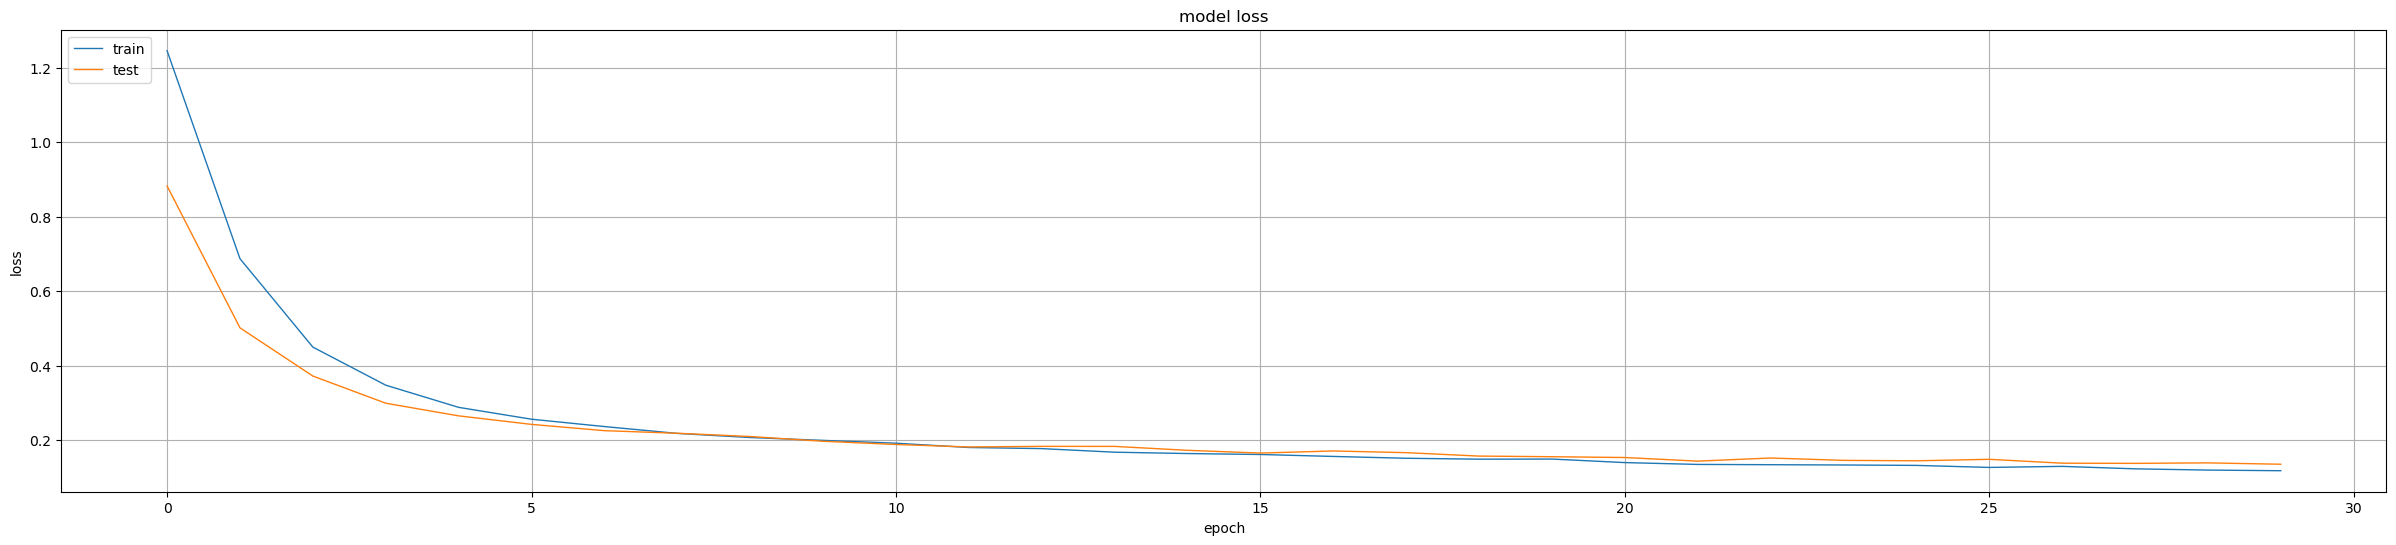

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

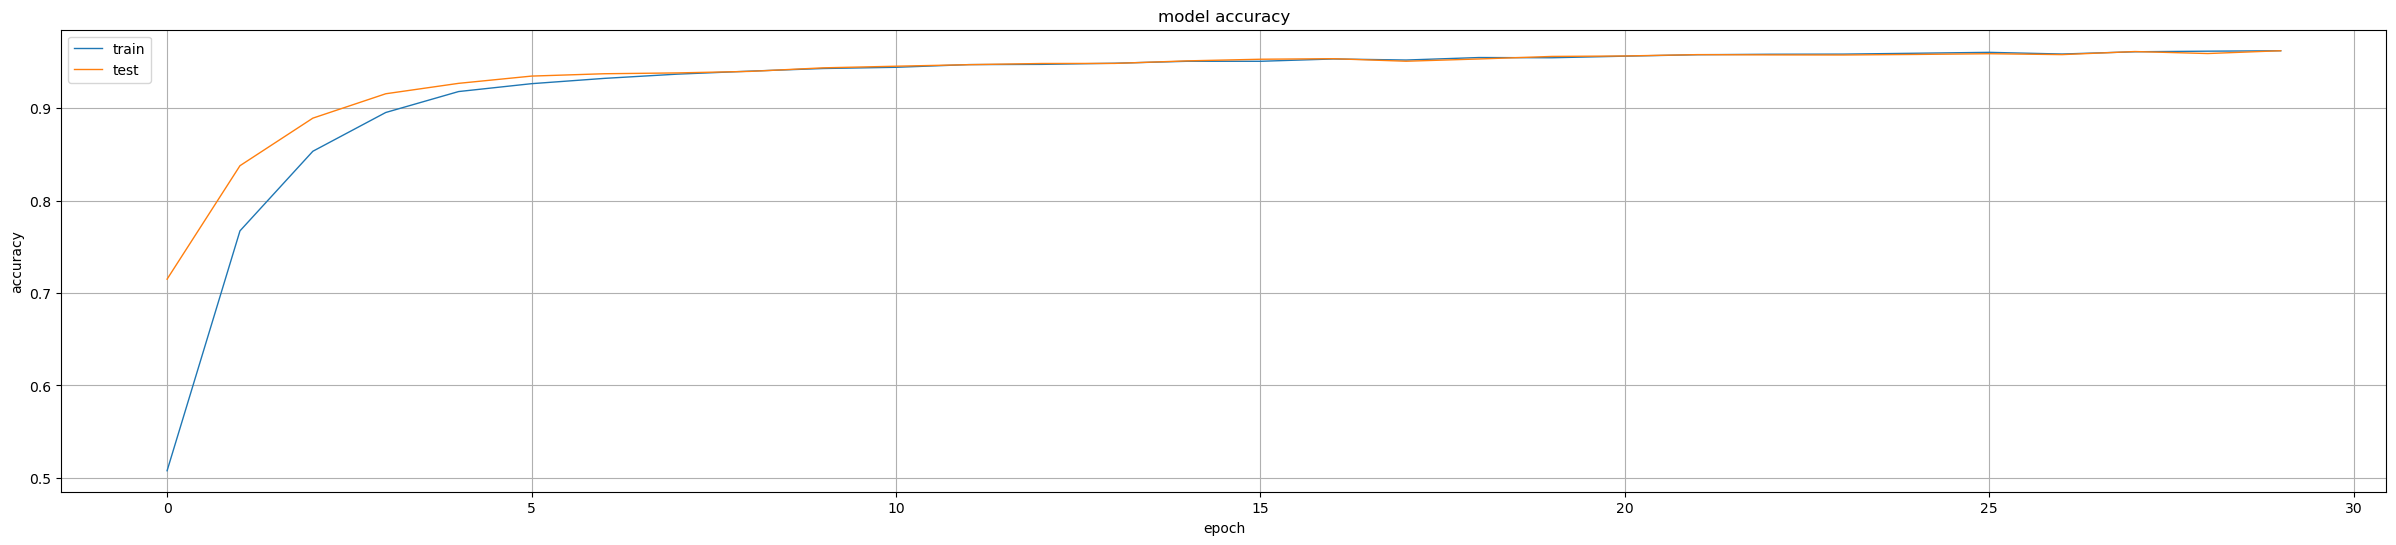

In [12]:
# summarize history for accuracy
plt.plot(history.history['custom_accuracy'])
plt.plot(history.history['val_custom_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [13]:
score = model.evaluate(test_x, test_y)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 5ms/step - loss: 0.1350 - custom_accuracy: 0.9618
Test Loss: 0.1349959373474121
Test accuracy: 0.9617834687232971


In [14]:
ei.model.list_profile_devices()

['alif-he',
 'alif-hp',
 'arduino-nano-33-ble',
 'arduino-nicla-vision',
 'portenta-h7',
 'brainchip-akd1000',
 'brickml',
 'cortex-m4f-80mhz',
 'cortex-m7-216mhz',
 'espressif-esp32',
 'himax-we-i',
 'infineon-cy8ckit-062s2',
 'infineon-cy8ckit-062-ble',
 'mbp-16-2020',
 'memryx-mx3',
 'nordic-nrf52840-dk',
 'nordic-nrf5340-dk',
 'nordic-nrf9160-dk',
 'jetson-nano',
 'jetson-orin-nx',
 'jetson-orin-nano',
 'openmv-h7p',
 'particle-p2',
 'raspberry-pi-4',
 'raspberry-pi-rp2040',
 'renesas-ck-ra6m5',
 'renesas-ek-ra8d1',
 'renesas-rzg2l',
 'renesas-rzv2l-cpu',
 'renesas-rzv2l',
 'st-iot-discovery-kit',
 'seeed-sense-cap',
 'wio-terminal',
 'seeed-vision-ai',
 'silabs-xg24',
 'silabs-thunderboard-sense-2',
 'sony-spresense',
 'synaptics-ka10000',
 'ti-am62a',
 'ti-am68a',
 'ti-launchxl',
 'ti-tda4vm',
 'neox']

In [15]:
try:
    profile = ei.model.profile(model=model, device='arduino-nano-33-ble')
    print(profile.summary())
except Exception as e:
    print(f"Could not profile:{e}")

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpv51ivys3\saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpv51ivys3\saved_model\assets


Target results for float32:
{
    "device": "arduino-nano-33-ble",
    "tfliteFileSizeBytes": 17692,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 13492,
            "rom": 68664,
            "arenaSize": 13100
        },
        "eon": {
            "ram": 9000,
            "rom": 39896
        }
    },
    "timePerInferenceMs": 102
}


Performance on device types:
{
    "variant": "float32",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 270,
        "memory": {
            "tflite": {
                "ram": 13339,
                "rom": 56872
            },
            "eon": {
                "ram": 8888,
                "rom": 36632
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 4,
        "memory": {
     

In [16]:
ei.model.list_deployment_targets()

['zip',
 'arduino',
 'tinkergen',
 'cubemx',
 'wasm',
 'wasm-browser-simd',
 'wasm-node-simd',
 'tensorrt',
 'ethos',
 'synaptics-tensaiflow-lib',
 'drp-ai-lib',
 'meta-tf',
 'tidl-lib',
 'memryx-dfp',
 'tidl-lib-am62a',
 'tidl-lib-am68a',
 'slcc',
 'disco-l475vg',
 'arduino-nano-33-ble-sense',
 'arduino-nicla-vision',
 'runner-linux-aarch64-advantech-icam540',
 'espressif-esp32',
 'raspberry-pi-rp2040',
 'arduino-portenta-h7',
 'silabs-thunderboard2',
 'silabs-xg24',
 'himax-we-i',
 'himax-we-i-gnu',
 'infineon-cy8ckit-062s2',
 'infineon-cy8ckit-062-ble',
 'nordic-nrf52840-dk',
 'nordic-nrf5340-dk',
 'nordic-nrf9160-dk',
 'nordic-thingy53',
 'nordic-thingy53-nrf7002eb',
 'nordic-thingy91',
 'nordic-nrf7002-dk',
 'openmv',
 'openmv-fw',
 'sony-spresense',
 'sony-spresense-commonsense',
 'ti-launchxl',
 'synaptics-ka10000',
 'renesas-ck-ra6m5',
 'brickml',
 'brickml-module',
 'renesas-ek-ra8d1',
 'alif-ensemble-e7',
 'seeed-grove-vision-ai',
 'seeed-sensecap',
 'runner-linux-aarch64',
 

In [17]:
try:
    ei.model.deploy(model=model,
                    model_output_type=ei.model.output_type.Classification(),
                    deploy_target = 'arduino',
                    output_directory=".")
except Exception as e:
    print(f"Could not deploy: {e}")

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpb2u1pelg\saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpb2u1pelg\saved_model\assets
